In [ ]:
!pip install pmdarima

import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from pandas.plotting import lag_plot
from pandas import datetime
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

     |████████████████████████████████| 1.5MB 26.6MB/s 
     |████████████████████████████████| 9.5MB 48.8MB/s 
  Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  import sys


In [ ]:
df = pd.read_csv('/content/UNVR.JK.csv')
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2003-09-03,615.0,675.0,605.0,675.0,395.962769,43162500
1,2003-09-04,690.0,750.0,675.0,685.0,401.828796,82850000
2,2003-09-05,685.0,700.0,680.0,690.0,404.761993,24055000
3,2003-09-08,690.0,690.0,665.0,680.0,398.895813,18007500
4,2003-09-09,680.0,680.0,660.0,665.0,390.096558,14075000


In [ ]:
df.isna().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4355 entries, 0 to 4354
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       4355 non-null   object 
 1   Open       4355 non-null   float64
 2   High       4355 non-null   float64
 3   Low        4355 non-null   float64
 4   Close      4355 non-null   float64
 5   Adj Close  4355 non-null   float64
 6   Volume     4355 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 238.3+ KB


In [ ]:
df.shape

(4355, 7)

In [ ]:
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date',inplace=True)

In [ ]:
df_train = df[0:int(len(df)*0.8)]
df_test = df[int(len(df)*0.8):]

In [ ]:
df_train.shape

(3484, 6)

In [ ]:
df_test.shape

(871, 6)

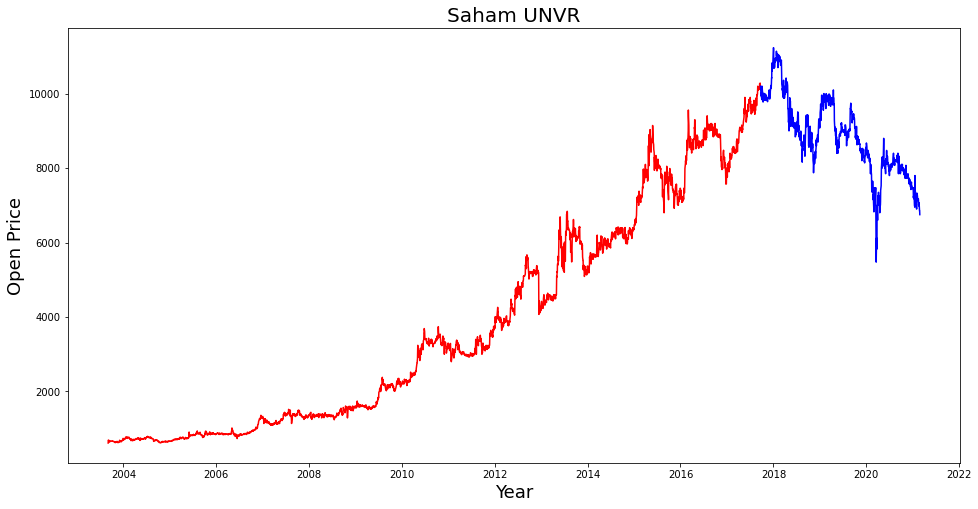

In [ ]:
plt.figure(figsize=(16,8))
plt.title('Saham UNVR', fontsize = 20)
plt.plot(df_train['Open'], color='red')
plt.plot(df_test['Open'], color='blue')
plt.xlabel('Year', fontsize = 18)
plt.ylabel('Open Price', fontsize = 18)
plt.show()

In [ ]:
import warnings 
warnings.filterwarnings('ignore')

In [ ]:
from pmdarima import auto_arima
stepwise_fit = auto_arima(df['Open'], trace=True,
suppress_warnings=True)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=52529.678, Time=4.92 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=52603.660, Time=0.12 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=52554.068, Time=0.14 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=52545.700, Time=0.92 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=52602.497, Time=0.07 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=52528.614, Time=3.36 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=52528.647, Time=0.42 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=52526.879, Time=1.71 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=52528.665, Time=2.58 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=52530.868, Time=0.41 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=52526.350, Time=0.63 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=52544.813, Time=0.16 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=52553.109, Time=0.12 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=52528.184, Time=0.68 sec
 ARIMA(1,1,2)(0,0,0

In [ ]:
training_ar = df_train['Open'].values
test_ar = df_test['Open'].values

history = [x for x in training_ar]
print(type(history))
predictions = []

for t in range(len(test_ar)):
    model = ARIMA(history, order=(1,1,1))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test_ar[t]
    history.append(obs)
    
print(model_fit.aic)
error = mean_squared_error(test_ar, predictions)
print('Testing Mean Squared Error: %.3f' % error)

<class 'list'>
52514.581046336534
Testing Mean Squared Error: 22621.648


In [ ]:
predict = np.array(predictions)

df_results = pd.DataFrame()
df_results['Real'] = df_test['Open'].reset_index(drop = True)
df_results['Predict'] = predict
df_results.tail()

,Real,Predict
866,6975.0,6990.081184
867,6900.0,6985.209868
868,6850.0,6915.949080
869,6850.0,6866.596339
870,6750.0,6861.122744


In [ ]:
df_results.to_excel("testing_arima.xlsx")

In [ ]:
r2 = r2_score(df_results['Real'], df_results['Predict'])
r2 = r2 * 100
print ('Koefisien Determinasi : ' "{:.2f}".format(r2)+' %')

def mape(actual, pred): 
    actual, pred = np.array(actual), np.array(pred)
    return np.mean(np.abs((actual - pred) / actual)) * 100
mape1 = mape(df_results['Real'], df_results['Predict'])
print ('Mean Absolute Persentage Error : ' "{:.2f}".format(mape1)+' %')

Koefisien Determinasi : 97.85 %
Mean Absolute Persentage Error : 1.21 %


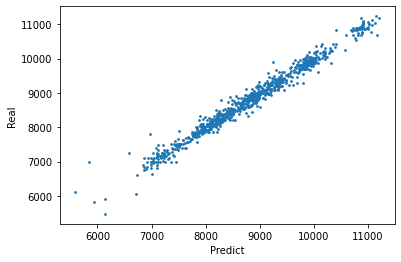

In [ ]:
plt.scatter(x = df_results['Predict'], y = df_results['Real'], s = 3)
plt.xlabel('Predict', fontsize = 10)
plt.ylabel('Real', fontsize = 10)
plt.show()

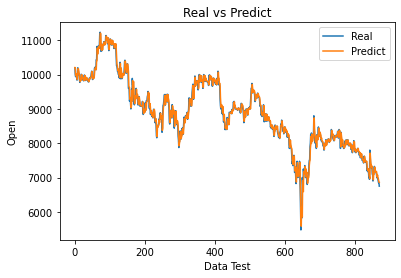

In [ ]:
plt.plot(df_results['Real'])
plt.plot(df_results['Predict'])
plt.xlabel('Data Test', fontsize = 10)
plt.ylabel('Open', fontsize = 10)
plt.legend(['Real', 'Predict'])
plt.title('Real vs Predict')
plt.show()